In [1]:
import numpy as np
import tensorflow as tf

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.WARN)
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

import sys
import os
import threading
from threading import Thread, Lock
import h5py
import re
import datetime

from skimage import data, color
from skimage.transform import rescale, resize, downscale_local_mean, rotate, AffineTransform, warp
from skimage.io import imread, imsave
import tifffile as tiff
import matplotlib.pyplot as plt

import imgaug
import imgaug.augmenters as iaa
from imgaug.augmentables.segmaps import SegmentationMapsOnImage
import random
import PIL.Image
import PIL.ImageEnhance
import PIL.ImageOps
import copy

from tensorflow.keras import backend as K
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.preprocessing.image import random_rotation, random_shift, random_shear, random_zoom, random_channel_shift
from tensorflow.keras.utils import array_to_img, img_to_array, load_img, to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard
from tensorflow.keras.layers import Layer, InputSpec
from tensorflow.keras.optimizers.experimental import SGD

import glob, fnmatch

from models import inceptionV3 as inceptionV3

from helpers import *

2023-07-04 13:12:58.175348: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-04 13:13:07.567558: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/sathlerar/data/conda/lib:/usr/local/CUDA/11.3.0/bin:/usr/local/CUDA/11.3.0/targets/x86_64-linux/lib:/usr/local/cuDNN/8.2.1/CUDA-11.3/lib64:/usr/bin
2023-07-04 13:13:07.568056: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or dire

In [2]:
from matplotlib import pyplot as plt

In [3]:
def preprocessing(nb_trainings, parameters):
    for i in range(nb_trainings):
        if type(parameters[0]) == np.ndarray:
            if parameters[0][i].selected==None:
                sys.exit("Preprocessing #"+str(i+1)+": You need to select an input directory for preprocessing")
            if parameters[1][i].selected==None:
                sys.exit("Preprocessing #"+str(i+1)+": You need to select an output directory for preprocessed data")
            
            preprocess(parameters[0][i].selected, parameters[1][i].selected, 
                       parameters[2][i].children[1].value, parameters[3][i].children[1].value, 
                       parameters[4][i].children[1].value, parameters[5][i].children[1].value)
        else:
            if not os.path.isdir(parameters[0]):
                sys.exit("Preprocessing #"+str(i+1)+": You need to select an input directory for preprocessing")
            if not os.path.isdir(parameters[1]):
                sys.exit("Preprocessing #"+str(i+1)+": You need to select an input directory for preprocessed data")
            
            preprocess(parameters[0], parameters[1], parameters[2],
                       parameters[3], parameters[4], parameters[5])

In [4]:
J_ROOT = os.readlink('/proc/%s/cwd' % os.environ['JPY_PARENT_PID'])
input_dir = os.path.join(J_ROOT, '23-07-04_model', '23-07-04_annotation', 'nucleiSegmentation')
pad_dir = os.path.join(J_ROOT, '23-07-04_model', '23-07-04_annotation_padded', 'nucleiSegmentation')
output_dir = os.path.join(J_ROOT, '23-07-04_model', '23-07-04_annotation_npz', 'nucleiSegmentation')
nb_classes = 3
window_size_x = 32
window_size_y = 32
normalization = 'nuclei segmentation'
#parameters = [input_dir, output_dir, nb_classes, window_size_x, window_size_y, normalization]

In [5]:
# search images to find smallest dimension
largest = get_largest_dim(getfiles(input_dir))
print(f"The largest image dimensions is {largest}. All images will be zero-padded to {largest}x{largest}\n")

The largest image dimensions is 1076. All images will be zero-padded to 1076x1076



In [6]:
%%capture
#generate crops
image_directories = [i for i in os.listdir(input_dir)]

NUM_CROPS = 18
BATCH_SIZE = 1


pad_list = []
for directory in image_directories:
    #crops will be shared for all features of a single image
    for image in os.listdir(os.path.join(input_dir, directory)):
        if image == '.ipynb_checkpoints' or image == "Thumbs.db" or image == ".DS_Store":
            continue

        im = get_image(os.path.join(input_dir, directory, image))

        value = get_closest_val(np.mean(im), (np.iinfo(im.dtype).min, np.iinfo(im.dtype).max))

        padded = np.full((largest, largest), value)
        padded[:im.shape[0],:im.shape[1]] = im

        padded = np.float32(padded)

        savedir = os.path.join(pad_dir, directory)
        if not os.path.isdir(savedir):
            os.makedirs(savedir)
            
        savepath = os.path.join(savedir, image)
        pad_list.append(padded)
        imsave(savepath, padded)

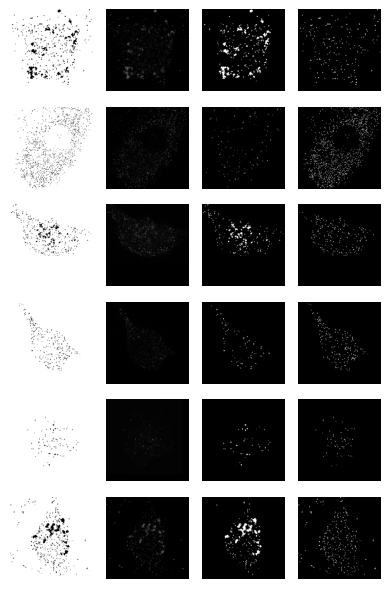

In [7]:
rows = len(image_directories)
cols = 4
plt.figure(figsize=(cols, rows))
for num, x in enumerate(pad_list):
    plt.subplot(rows,cols,num+1)
    plt.axis('off')
    plt.imshow(x, cmap = "gray")

plt.tight_layout()

In [8]:
direc_name = pad_dir
file_name_save = os.path.join(output_dir, 'data.npz')
training_direcs = [i for i in os.listdir(direc_name)]
channel_names = ["image"]

# maximum number of training cases
max_training_examples = 10000000

nb_direcs = len(training_direcs)
nb_channels = len(channel_names)

# variables for images
imglist = []
for direc in training_direcs:
    imglist += getfiles(direc)

In [9]:
# Initialize arrays for the training images and the classes
channels = np.zeros((nb_direcs, largest, largest, nb_channels), dtype='float32')
class_mask = np.zeros((nb_direcs, largest, largest, nb_classes), dtype='float32')

In [10]:
direc_counter = 0
for ddx, direc in enumerate(training_direcs):
    imglist = os.listdir(os.path.join(direc_name, direc))
    channel_counter = 0

    # Load channels
    print("\nLoading channels")
    for idx, channel in enumerate(channel_names):
        for jdx, img in enumerate(imglist):
            if fnmatch.fnmatch(img, r'*' + channel + r'*'):
                print(f"Processing base image {ddx + 1}/{len(training_direcs)}")
                
                channel_img = get_image(os.path.join(direc_name, direc, img))
                
                channel_img = process_image(channel_img, 2*window_size_x + 1, 2*window_size_y + 1)
                
                channels[direc_counter,:,:,channel_counter] = channel_img
                channel_counter += 1

    # Load class mask
    print("\nLoading class masks")
    for j in range(nb_classes):
        class_name = "feature_" + str(j) + r".*"
        for kdx, img in enumerate(imglist):
            if fnmatch.fnmatch(img, class_name):
                print(f"Processing image {j + 1}/{len(imglist) - 1}")
                class_file = os.path.join(direc_name, direc, img)
                class_img = get_image(class_file)

                if np.sum(class_img) > 0:
                    class_img /= np.amax(class_img)

                class_mask[direc_counter,:,:,j] = class_img
   
    direc_counter += 1


Loading channels
Processing base image 1/6

Loading class masks
Processing image 1/3
Processing image 2/3
Processing image 3/3

Loading channels
Processing base image 2/6

Loading class masks
Processing image 1/3
Processing image 2/3
Processing image 3/3

Loading channels
Processing base image 3/6

Loading class masks
Processing image 1/3
Processing image 2/3
Processing image 3/3

Loading channels
Processing base image 4/6

Loading class masks
Processing image 1/3
Processing image 2/3
Processing image 3/3

Loading channels
Processing base image 5/6

Loading class masks
Processing image 1/3
Processing image 2/3
Processing image 3/3

Loading channels
Processing base image 6/6

Loading class masks
Processing image 1/3
Processing image 2/3
Processing image 3/3


In [11]:
class_mask_trimmed = class_mask[:,window_size_x+1:-window_size_x-1,window_size_y+1:-window_size_y-1,:] 

class_rows = []
class_cols = []
class_batch = []
class_label = []

min_pixel_counter = np.zeros((nb_direcs))
for j in range(class_mask_trimmed.shape[0]):
    min_pixel_counter[j] = np.Inf
    nb_pixels_class = 0
    for k in range(nb_classes):
        nb_pixels_class = np.sum(class_mask_trimmed[j,:,:,k])
        if nb_pixels_class < min_pixel_counter[j]:
            min_pixel_counter[j] = nb_pixels_class
            
for direc in range(channels.shape[0]):
    
    for k in range(nb_classes):
        class_counter = 0
        class_rows_temp, class_cols_temp = np.where(class_mask[direc,:,:,k] == 1)

        if len(class_rows_temp) > 0:

            # Randomly permute index vector
            non_rand_ind = np.arange(len(class_rows_temp))
            rand_ind = np.random.choice(non_rand_ind, size = len(class_rows_temp), replace = False)

            for i in rand_ind:
                if class_counter < min_pixel_counter[direc]:
                    if (class_rows_temp[i] - window_size_x > 0) and (class_rows_temp[i] + window_size_x < largest): 
                        if (class_cols_temp[i] - window_size_y > 0) and (class_cols_temp[i] + window_size_y < largest):
                            class_rows += [class_rows_temp[i]]
                            class_cols += [class_cols_temp[i]]
                            class_batch += [direc]
                            class_label += [k]
                            class_counter += 1

class_rows = np.array(class_rows,dtype = 'int32')
class_cols = np.array(class_cols,dtype = 'int32')
class_batch = np.array(class_batch, dtype = 'int32')
class_label = np.array(class_label, dtype = 'int32')

# Randomly select training points 
if len(class_rows) > max_training_examples:
    non_rand_ind = np.arange(len(class_rows))
    rand_ind = np.random.choice(non_rand_ind, size = max_training_examples, replace = False)

    class_rows = class_rows[rand_ind]
    class_cols = class_cols[rand_ind]
    class_batch = class_batch[rand_ind]
    class_label = class_label[rand_ind]

# Randomize
non_rand_ind = np.arange(len(class_rows))
rand_ind = np.random.choice(non_rand_ind, size = len(class_rows), replace = False)

class_rows = class_rows[rand_ind]
class_cols = class_cols[rand_ind]
class_batch = class_batch[rand_ind]
class_label = class_label[rand_ind]

np.savez(file_name_save, channels = channels, y = class_label, 
         batch = class_batch, pixels_x = class_rows, pixels_y = class_cols, 
         win_x = window_size_x, win_y = window_size_y)